In [1]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import math

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import XGBClassifier

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras

mpl.rc('axes', labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

Using TensorFlow backend.
C:\Users\server\anaconda3\envs\ksa2020\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\server\anaconda3\envs\ksa2020\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\server\anaconda3\envs\ksa2020\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\server\anaconda3\envs\ksa2020

In [2]:
# loss 그래프 그리는 함수
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'val'], loc=0)

# accuracy 그래프 그리는 함수
def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'val'], loc=0)


In [3]:
PROJECT_ROOT_DIR="."
CHAPTER_ID="basketball_project"
IMAGES_PATH=os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID)
os.makedirs(IMAGES_PATH,exist_ok=True)

def save_fig(fig_id,tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH,fig_id+"."+fig_extension)
    print("그림 저장:",fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)
    
import warnings
warnings.filterwarnings(action="ignore",message="^internal gelsd")

In [4]:
import pandas as pd

BASKETBALL_PATH = os.path.join("datasets","basketball")

def load_basketball_data(housing_path=BASKETBALL_PATH):
    csv_path = os.path.join(BASKETBALL_PATH,"summary.csv")
    return pd.read_csv(csv_path)

In [5]:
basketball = load_basketball_data()
basketball.head()

,Name,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalsAttempt,FieldGoalPercent,3PointMade,3PointAttempt,3PointPercent,...,FreeThrowAttempt,FreeThrowPercent,OffensiveRebounds,DefensiveRebounds,Rebounds,Assists,Steals,Blocks,Turnovers,Target
0,Zach Randolph,41,5.8,2.8,1.2,2.6,44.9,0.0,0.0,0.0,...,0.7,66.7,0.8,0.9,1.7,0.3,0.2,0.1,0.4,1
1,Zach LaVine,77,24.7,10.1,3.7,8.8,42.2,0.7,2.2,34.1,...,2.3,84.2,0.4,2.4,2.8,3.6,0.7,0.1,2.5,0
2,Xavier McDaniel,82,33.0,17.1,7.0,14.3,49.0,0.0,0.1,20.0,...,4.4,68.7,3.7,4.2,8.0,2.4,1.2,0.5,3.0,1
3,Winston Garland,67,31.7,12.4,5.1,11.6,43.9,0.2,0.6,33.3,...,2.3,87.9,1.0,2.4,3.4,6.4,1.7,0.1,2.5,1
4,Winston Bennett,55,18.0,6.1,2.5,5.2,47.9,0.0,0.0,0.0,...,1.7,66.7,1.5,1.9,3.4,1.0,0.4,0.2,1.1,0


In [6]:
basketball.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               1284 non-null   object 
 1   GamesPlayed        1284 non-null   int64  
 2   MinutesPlayed      1284 non-null   float64
 3   PointsPerGame      1284 non-null   float64
 4   FieldGoalsMade     1284 non-null   float64
 5   FieldGoalsAttempt  1284 non-null   float64
 6   FieldGoalPercent   1284 non-null   float64
 7   3PointMade         1284 non-null   float64
 8   3PointAttempt      1284 non-null   float64
 9   3PointPercent      1284 non-null   float64
 10  FreeThrowMade      1284 non-null   float64
 11  FreeThrowAttempt   1284 non-null   float64
 12  FreeThrowPercent   1284 non-null   float64
 13  OffensiveRebounds  1284 non-null   float64
 14  DefensiveRebounds  1284 non-null   float64
 15  Rebounds           1284 non-null   float64
 16  Assists            1284 

In [7]:
basketball.describe()

,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalsAttempt,FieldGoalPercent,3PointMade,3PointAttempt,3PointPercent,FreeThrowMade,FreeThrowAttempt,FreeThrowPercent,OffensiveRebounds,DefensiveRebounds,Rebounds,Assists,Steals,Blocks,Turnovers,Target
count,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000
mean,60.260125,17.591121,6.782710,2.619159,5.871963,44.108333,0.252570,0.790966,19.435047,1.292991,1.814720,70.400623,1.005841,2.015498,3.020405,1.542991,0.616199,0.368224,1.186994,0.625389
std,17.455547,8.263154,4.309459,1.663268,3.551383,6.094888,0.387612,1.070542,16.135688,0.977660,1.315017,10.461704,0.773804,1.352144,2.044559,1.460172,0.408487,0.432004,0.716846,0.484211
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.900000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.800000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,62.000000,16.100000,5.600000,2.100000,4.800000,43.900000,0.100000,0.300000,22.550000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.800000,8.800000,3.400000,7.500000,47.800000,0.400000,1.200000,32.800000,1.600000,2.300000,77.500000,1.400000,2.600000,3.900000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


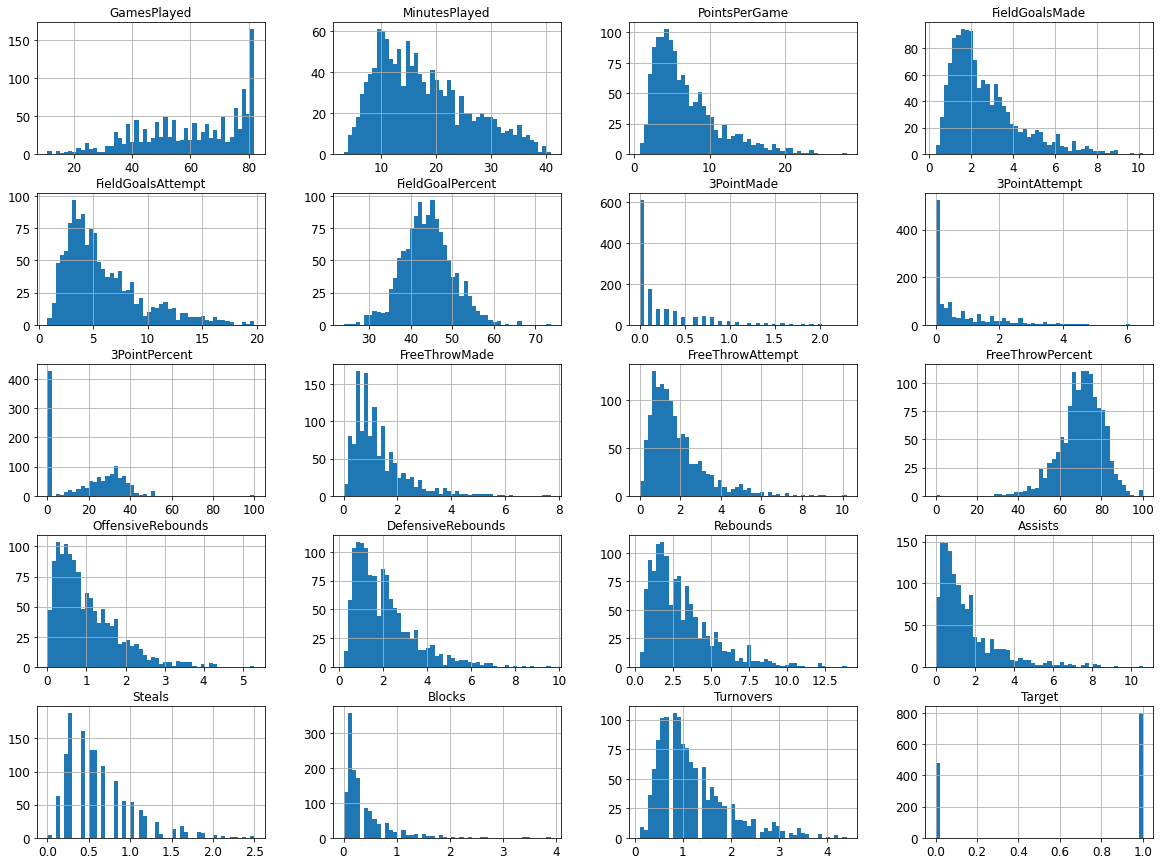

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
basketball.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
from pandas.plotting import scatter_matrix
corr_matrix=basketball[basketball['Target']==0].corr()

In [10]:
corr_matrix

,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalsAttempt,FieldGoalPercent,3PointMade,3PointAttempt,3PointPercent,FreeThrowMade,FreeThrowAttempt,FreeThrowPercent,OffensiveRebounds,DefensiveRebounds,Rebounds,Assists,Steals,Blocks,Turnovers,Target
GamesPlayed,1.000000,0.443247,0.430496,0.434824,0.409910,0.252715,0.097218,0.088240,0.020889,0.380110,0.366230,0.176704,0.263963,0.320437,0.320646,0.290915,0.307931,0.170251,0.400586,NaN
MinutesPlayed,0.443247,1.000000,0.880504,0.859806,0.886571,0.150688,0.490795,0.499826,0.211314,0.736150,0.709603,0.253823,0.451061,0.732094,0.674873,0.622757,0.731157,0.369102,0.764970,NaN
PointsPerGame,0.430496,0.880504,1.000000,0.987527,0.974642,0.264725,0.423740,0.419561,0.180469,0.863327,0.828848,0.282532,0.477101,0.652916,0.630680,0.517724,0.608935,0.354349,0.783264,NaN
FieldGoalsMade,0.434824,0.859806,0.987527,1.000000,0.967325,0.321604,0.344557,0.340363,0.140400,0.804905,0.778797,0.238856,0.518992,0.665948,0.655106,0.488676,0.584320,0.372245,0.764246,NaN
FieldGoalsAttempt,0.409910,0.886571,0.974642,0.967325,1.000000,0.108289,0.475965,0.488686,0.227279,0.792207,0.748827,0.293364,0.394701,0.609208,0.569403,0.568515,0.616457,0.286986,0.789912,NaN
FieldGoalPercent,0.252715,0.150688,0.264725,0.321604,0.108289,1.000000,-0.290746,-0.348975,-0.283759,0.218518,0.276828,-0.134740,0.528526,0.342213,0.434934,-0.125552,0.061587,0.339787,0.091957,NaN
3PointMade,0.097218,0.490795,0.423740,0.344557,0.475965,-0.290746,1.000000,0.978851,0.615324,0.208581,0.124921,0.337934,-0.246788,0.146559,0.008692,0.400175,0.336974,-0.093427,0.272204,NaN
3PointAttempt,0.088240,0.499826,0.419561,0.340363,0.488686,-0.348975,0.978851,1.000000,0.597574,0.212317,0.126304,0.348081,-0.260534,0.143672,0.001366,0.424586,0.357061,-0.102916,0.287168,NaN
3PointPercent,0.020889,0.211314,0.180469,0.140400,0.227279,-0.283759,0.615324,0.597574,1.000000,0.010072,-0.057217,0.283097,-0.332634,-0.070113,-0.173199,0.290248,0.216397,-0.222672,0.101082,NaN
FreeThrowMade,0.380110,0.736150,0.863327,0.804905,0.792207,0.218518,0.208581,0.212317,0.010072,1.000000,0.974553,0.277197,0.470976,0.554571,0.561403,0.438464,0.542438,0.350828,0.741231,NaN


In [11]:
features = basketball.columns.drop(['Name','Target','FieldGoalsAttempt','Blocks','Assists','3PointPercent','3PointMade','Steals','3PointAttempt','FreeThrowPercent','DefensiveRebounds','Turnovers'])
#,'MinutesPlayed','FieldGoalsMade','FieldGoalsAttempt','3PointMade','3PointAttempt','FreeThrowMade','FreeThrowAttempt','DefensiveRebounds'])

print("원본 features : ",basketball.columns)
print()
print("학습모델 features : ",features)

원본 features :  Index(['Name', 'GamesPlayed', 'MinutesPlayed', 'PointsPerGame',
       'FieldGoalsMade', 'FieldGoalsAttempt', 'FieldGoalPercent', '3PointMade',
       '3PointAttempt', '3PointPercent', 'FreeThrowMade', 'FreeThrowAttempt',
       'FreeThrowPercent', 'OffensiveRebounds', 'DefensiveRebounds',
       'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers', 'Target'],
      dtype='object')

학습모델 features :  Index(['GamesPlayed', 'MinutesPlayed', 'PointsPerGame', 'FieldGoalsMade',
       'FieldGoalPercent', 'FreeThrowMade', 'FreeThrowAttempt',
       'OffensiveRebounds', 'Rebounds'],
      dtype='object')


In [12]:
basketball_bak = basketball
scaler = MinMaxScaler()
basketball_nomalize = pd.DataFrame(scaler.fit_transform(basketball.drop(['Name','Target'],axis=1)),columns=basketball_bak.columns.drop(['Name','Target']))

In [13]:
basketball_nomalize = basketball_nomalize.loc[:,features]

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(basketball_nomalize, basketball_bak['Target'],test_size=0.2,random_state=42)


In [15]:
x_train

,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalPercent,FreeThrowMade,FreeThrowAttempt,OffensiveRebounds,Rebounds
788,0.352113,0.150794,0.130909,0.131313,0.474950,0.142857,0.176471,0.113208,0.080882
850,0.746479,0.526455,0.363636,0.353535,0.406814,0.402597,0.460784,0.264151,0.227941
1087,0.887324,0.449735,0.298182,0.313131,0.406814,0.116883,0.117647,0.094340,0.198529
1269,0.859155,0.626984,0.218182,0.212121,0.372745,0.220779,0.215686,0.339623,0.360294
135,0.647887,0.142857,0.138182,0.151515,0.408818,0.116883,0.088235,0.075472,0.051471
...,...,...,...,...,...,...,...,...,...
1044,0.718310,0.293651,0.178182,0.181818,0.494990,0.181818,0.235294,0.320755,0.250000
1095,0.690141,0.132275,0.087273,0.111111,0.513026,0.051948,0.068627,0.150943,0.169118
1130,0.788732,0.359788,0.156364,0.171717,0.492986,0.116883,0.147059,0.169811,0.176471
860,0.521127,0.068783,0.014545,0.010101,0.000000,0.038961,0.039216,0.037736,0.022059


In [16]:
y_train

788     0
850     1
1087    1
1269    1
135     1
       ..
1044    1
1095    1
1130    1
860     0
1126    1
Name: Target, Length: 1027, dtype: int64

In [17]:
x_test

,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalPercent,FreeThrowMade,FreeThrowAttempt,OffensiveRebounds,Rebounds
1244,1.000000,0.785714,0.301818,0.303030,0.511022,0.246753,0.254902,0.207547,0.397059
331,0.366197,0.145503,0.050909,0.060606,0.250501,0.025974,0.029412,0.113208,0.088235
1005,0.830986,1.000000,0.665455,0.666667,0.376754,0.441558,0.411765,0.150943,0.272059
411,0.577465,0.325397,0.138182,0.151515,0.515030,0.129870,0.137255,0.226415,0.220588
1204,0.816901,0.269841,0.160000,0.171717,0.452906,0.090909,0.078431,0.094340,0.161765
...,...,...,...,...,...,...,...,...,...
614,0.887324,0.224868,0.087273,0.101010,0.356713,0.077922,0.088235,0.150943,0.117647
796,0.802817,0.198413,0.123636,0.121212,0.410822,0.142857,0.166667,0.113208,0.132353
333,0.647887,0.317460,0.149091,0.171717,0.623246,0.116883,0.137255,0.245283,0.235294
990,0.732394,0.214286,0.116364,0.141414,0.515030,0.064935,0.078431,0.169811,0.161765


In [18]:
y_test

1244    1
331     0
1005    1
411     1
1204    1
       ..
614     1
796     1
333     1
990     1
700     0
Name: Target, Length: 257, dtype: int64

In [19]:
from sklearn.svm import SVC

svm_clf = SVC(C=1,kernel='rbf',gamma=0.1,random_state=42)
svm_clf.fit(x_train,y_train)

SVC(C=1, gamma=0.1, random_state=42)

In [20]:
y_pred_svc = svm_clf.predict(x_test)
print(sklearn.metrics.classification_report(y_test, y_pred_svc))
print('Test accuracy:', accuracy_score(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.68      0.51      0.58        91
           1       0.76      0.87      0.81       166

    accuracy                           0.74       257
   macro avg       0.72      0.69      0.69       257
weighted avg       0.73      0.74      0.73       257

Test accuracy: 0.7392996108949417


In [21]:
from sklearn.model_selection import GridSearchCV

# XGBoost 분류기 생성
xgb_clf = xgb.XGBClassifier()

# 초모수 격자생성
xgb_param_grid = {
                'n_estimators' : range(100,800,100),
                'max_depth': [1], 
                'subsample': [0.3],
                'learning_rate':[0.01]
}

# Create a GridSearchCV object
hr_grid = GridSearchCV(estimator=xgb_clf,
                       param_grid=xgb_param_grid,
                       scoring='roc_auc',
                       n_jobs=8,
                       cv=5,
                       refit=True, 
                       return_train_score=True)

hr_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [22]:
hr_grid_df = pd.DataFrame(hr_grid.cv_results_)
hr_grid_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,0.117486,0.001596,0.002593,4.886555e-04,0.01,1,600,0.3,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.826022,...,0.761975,0.039879,1,0.779810,0.787290,0.793703,0.800119,0.805820,0.793348,0.009182
4,0.096542,0.001716,0.002194,3.990889e-04,0.01,1,500,0.3,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.827524,...,0.761444,0.041207,2,0.776116,0.783575,0.789762,0.795978,0.802674,0.789621,0.009271
3,0.078988,0.002555,0.002393,4.886166e-04,0.01,1,400,0.3,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.828726,...,0.761162,0.041186,3,0.772049,0.780294,0.785671,0.791736,0.797716,0.785493,0.008901
6,0.132650,0.001404,0.002593,4.886166e-04,0.01,1,700,0.3,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.824619,...,0.760788,0.039807,4,0.782637,0.790250,0.796305,0.803224,0.809496,0.796382,0.009437
2,0.060637,0.001323,0.002194,3.988266e-04,0.01,1,300,0.3,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.829026,...,0.760257,0.041469,5,0.766816,0.775843,0.782677,0.787535,0.794052,0.781384,0.009412
1,0.099529,0.046719,0.001994,2.132481e-07,0.01,1,200,0.3,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.826773,...,0.758285,0.042051,6,0.762310,0.771857,0.779981,0.782501,0.789957,0.777321,0.009474
0,0.105528,0.015091,0.002387,4.842877e-04,0.01,1,100,0.3,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",0.818660,...,0.754751,0.039023,7,0.760384,0.767745,0.777306,0.778796,0.785910,0.774028,0.008948


In [23]:
y_pred_x = hr_grid.predict(x_test)
print(sklearn.metrics.classification_report(y_test, y_pred_x))
print('Test accuracy:', accuracy_score(y_test, y_pred_x))

              precision    recall  f1-score   support

           0       0.68      0.52      0.59        91
           1       0.77      0.87      0.81       166

    accuracy                           0.74       257
   macro avg       0.72      0.69      0.70       257
weighted avg       0.74      0.74      0.73       257

Test accuracy: 0.7431906614785992


In [24]:
xgb_model = XGBClassifier(booster='gbtree',
                          scale_pos_weight=1,
                          learning_rate=0.01,  
                          colsample_bytree = 1,
                          objective='binary:logistic', 
                          n_estimators=700, 
                          max_depth=1, 
                          gamma=0,
                          subsample=0.3,
                          seed=42,
                          eta=0.3
                         )
xgb_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.3, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [25]:
y_pred_xgb = xgb_model.predict(x_test)
y_pred_xgb = np.around(y_pred_xgb)

print(sklearn.metrics.classification_report(y_test, y_pred_xgb))
print('Test accuracy:', accuracy_score(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.72      0.57      0.64        91
           1       0.79      0.88      0.83       166

    accuracy                           0.77       257
   macro avg       0.76      0.73      0.73       257
weighted avg       0.77      0.77      0.76       257

Test accuracy: 0.7704280155642024


In [26]:
import operator

feature_importance = {}
temp = xgb_model.feature_importances_
for i in range(len(temp)):
    feature_importance[features[i]] = temp[i]

sorted(feature_importance.items(), reverse=True, key=operator.itemgetter(1))

[('GamesPlayed', 0.16397157),
 ('FreeThrowMade', 0.1246163),
 ('FieldGoalsMade', 0.1212104),
 ('PointsPerGame', 0.11754963),
 ('FieldGoalPercent', 0.104613036),
 ('FreeThrowAttempt', 0.09752279),
 ('OffensiveRebounds', 0.09554719),
 ('Rebounds', 0.089207724),
 ('MinutesPlayed', 0.08576141)]

In [27]:
rf = RandomForestClassifier(n_estimators=400, oob_score=True, random_state=42,)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=400, oob_score=True, random_state=42)

In [28]:
y_pred_rf = rf.predict(x_test)

print(sklearn.metrics.classification_report(y_test, y_pred_rf))
print('Test accuracy:', accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.60      0.43      0.50        91
           1       0.73      0.84      0.78       166

    accuracy                           0.70       257
   macro avg       0.66      0.64      0.64       257
weighted avg       0.68      0.70      0.68       257

Test accuracy: 0.6964980544747081


In [29]:
def create_deep_model():
    input_shape = features.shape
    input_tensor = keras.layers.Input(shape=input_shape,name='input_tensor')
    x = keras.layers.Dense(units=256, name='hidden_1')(input_tensor)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(units=512, name='hidden_2')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(units=256, name='hidden_3')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    output_tensor = keras.layers.Dense(1, activation='sigmoid',name='last_activate')(x)
    model = keras.models.Model(inputs=input_tensor, outputs=output_tensor)
    
    optimizer = keras.optimizers.Adamax(lr=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [30]:
# from tensorflow.keras.utils import to_categorical

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# print(y_train)

In [31]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=2, mode='auto')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=0.0005)

model = create_deep_model()
history = model.fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=2)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1027 samples, validate on 257 samples
Epoch 1/20
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6248 - acc: 0.6203 - val_loss: 0.5995 - val_acc: 0.6498
Epoch 2/20
1027/1027 [==============================] - 0s 139us/step - loss: 0.6067 - acc: 0.6261 - val_loss: 0.5737 - val_acc: 0.6615
Epoch 3/20
1027/1027 [==============================] - 0s 134us/step - loss: 0.5992 - acc: 0.6378 - val_loss: 0.5632 - val_acc: 0.6926
Epoch 4/20
1027/1027 [==============================] - 0s 133us/step - loss: 0.5893 - acc: 0.6582 - val_loss: 0.5638 - val_acc: 0.7004
Epoch 5/20
1027/1027 [==============================] - 0s 133us/step - loss: 0.5821 - acc: 0.6943 - val_loss: 0.5679 - val_acc: 0.6965
Epoch 6/20
1027/1027 [==================

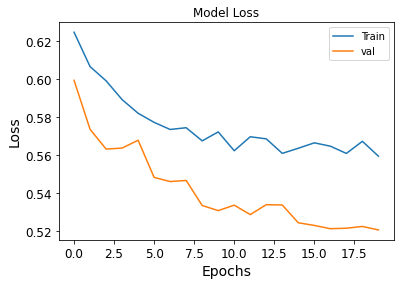

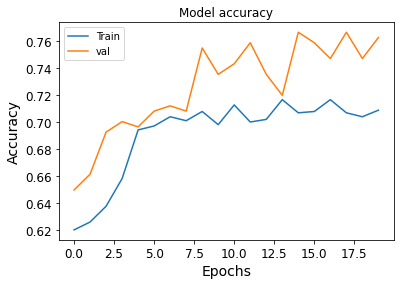

In [32]:
plot_loss(history)
plt.show()
plot_acc(history)
plt.show()

In [33]:
def create_model():
    input_shape = features.shape
    input_tensor = keras.layers.Input(shape=input_shape,name='input_tensor')
    x = keras.layers.Dense(units=20, name='hidden_1')(input_tensor)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(units=50, name='hidden_2')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(units=20, name='hidden_3')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    output_tensor = keras.layers.Dense(1, activation='sigmoid',name='last_activate')(x)
    model = keras.models.Model(inputs=input_tensor, outputs=output_tensor)
    
    optimizer = keras.optimizers.Adamax(lr=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
epochs = 5
model1 = KerasClassifier(build_fn = create_deep_model, epochs = epochs, verbose = 0)
model1._estimator_type="classifier"
model2 = KerasClassifier(build_fn = create_deep_model, epochs = epochs, verbose = 0)
model2._estimator_type="classifier"
model3 = KerasClassifier(build_fn = create_deep_model, epochs = epochs, verbose = 0)
model3._estimator_type="classifier"
model4 = KerasClassifier(build_fn = create_deep_model, epochs = epochs, verbose = 0)
model4._estimator_type="classifier"
model5 = KerasClassifier(build_fn = create_deep_model, epochs = epochs, verbose = 0)
model5._estimator_type="classifier"
model6 = KerasClassifier(build_fn = create_deep_model, epochs = epochs, verbose = 0)
model6._estimator_type="classifier"
model7 = KerasClassifier(build_fn = create_deep_model, epochs = epochs, verbose = 0)
model7._estimator_type="classifier"
model8 = KerasClassifier(build_fn = create_deep_model, epochs = epochs, verbose = 0)
model8._estimator_type="classifier"
model9 = KerasClassifier(build_fn = create_deep_model, epochs = epochs, verbose = 0)
model9._estimator_type="classifier"

ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), ('model3', model3), ('model4', model4), ('model5', model5),
                                             ('model6', model6), ('model7', model7), ('model8', model8), ('model9', model9)], 
                                voting = 'soft')
ensemble_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('model1',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000017B3096C3C8>),
                             ('model2',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000017B3096C320>),
                             ('model3',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000017B3096C358>),
                             ('model4',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000017B...
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000017B3096C160>),
                             ('model6',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000017B3096C470>),
                             ('model7',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000017B3096C5F8>),
                   

In [35]:
y_pred = ensemble_clf.predict(x_test)

print(sklearn.metrics.classification_report(y_test, y_pred))
print('Test accuracy:', accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.32      0.44        91
           1       0.71      0.92      0.80       166

    accuracy                           0.71       257
   macro avg       0.70      0.62      0.62       257
weighted avg       0.70      0.71      0.67       257

Test accuracy: 0.708171206225681
